# <div align="center">SDP - Systèmes de décision</div>

### <div align="center">01-02-2025</div>

- Kiyoshi Araki

- GabrielSouza

- Lucas Tramonte


## Libraries

In [2]:
import math
import numpy as np
import pandas as pd 
import csv
from collections import OrderedDict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
%matplotlib inline
from gurobipy import *

## Data processing

In [3]:
number_of_bricks = 22
number_of_sr = 4

# Current Structure of Sales Territories :
sr_assignments_current = [(1, 4,  [4, 5, 6, 7, 8, 15]),
          (2, 14, [10, 11, 12, 13, 14]),
          (3, 16, [9, 16, 17, 18]),
          (4, 22, [1, 2, 3, 19, 20, 21, 22])    
         ]

In [4]:
bricks_index_values_file = "Assets/Data/bricks_index_values.csv"

# brick_workloads : dict[int : float] : associates a brick identifier j with its new index value v_j.
brick_workloads = dict()

# Loading data
with open(bricks_index_values_file) as bricksIndexValuesFile:
    reader = csv.DictReader(bricksIndexValuesFile)
    for row in reader:
        b = int(row['brick'])
        brick_workloads[b] = float(row['index_value'])
        
brick_rp_distances_file = "Assets/Data/brick_rp_distances.csv"

# distance_sr_brick : dict[(int, int) : float] : associates with the pair (i, j) of RP and brick identifiers, the distance separating i's office from the j brick
distance_sr_brick = dict()

# Loading data
with open(brick_rp_distances_file) as brickRpDistancesFile:
    reader = csv.DictReader(brickRpDistancesFile)
    for row in reader:
        b = int(row['brick'])
        for rpId in range(1, number_of_sr + 1):
            distance_sr_brick[(rpId, b)] = float(row[f'rp{rpId}'])

In [5]:
SR_set = set()
Center_Brick_Set = set()
Brick_List = list()

for rp, center_brick, bricks_assigned in sr_assignments_current:
    print(f'SR {rp}', f'Center Brick {center_brick}', f'Bricks assigned', *bricks_assigned)
    SR_set.add(rp)
    Center_Brick_Set.add(center_brick)
    Brick_List += bricks_assigned

Brick_List.sort()
assert Brick_List == list(range(1, number_of_bricks + 1))
assert Center_Brick_Set - set(Brick_List) == set()
assert SR_set == set(range(1, number_of_sr + 1))

SR 1 Center Brick 4 Bricks assigned 4 5 6 7 8 15
SR 2 Center Brick 14 Bricks assigned 10 11 12 13 14
SR 3 Center Brick 16 Bricks assigned 9 16 17 18
SR 4 Center Brick 22 Bricks assigned 1 2 3 19 20 21 22


In [6]:
assert brick_workloads[4] == 0.1516
assert brick_workloads[22] == 0.2531
assert distance_sr_brick[(1, 1)] == 16.16
assert distance_sr_brick[(2, 15)] == 2.32
assert distance_sr_brick[(3, 16)] == 0.00

# Step 1

## **Exercise**: 
Formulate and implement two mono-objective linear optimization models to solve the assignment problem using a distance and a disruption objective. Solve the instance with 22 Bricks and 4 Sales Representatives

Workload of each SR in the current solution for the new $v_j$ index values

In [7]:
SR = {} 
for j in range(0, number_of_sr):
    LinExpr = quicksum(brick_workloads[i] for i in sr_assignments_current[j][2]) 
    SR[f'SR{j+1}'] = round(LinExpr.getValue(),3)
    
SR_data = pd.DataFrame(list(SR.items()), columns=['i', 'Workload'])
SR_data

,i,Workload
0,SR1,0.951
1,SR2,1.338
2,SR3,0.705
3,SR4,1.007


In [8]:
# Define problem variables 

# -- Model initialization --
m = Model("rendu")

# Xij : dict[(int, int) : Var] : Assignment of brig j to SR office i
Xij = {(i, j) : m.addVar(vtype = GRB.BINARY, name=f'x_{i}_{j}') for i in range(1, number_of_sr + 1) for j in range(1, number_of_bricks + 1)}

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-01


Constraints

- Each brick is assigned to a single SR

$$\sum_{i = 1}^{4} x_{ij} = 1 \;\;\;\; \text{for all $j = 1 \dots 22$} \;\;\;$$

In [9]:
CONSTR = {j : m.addConstr(quicksum(Xij[(i,j)] for i in range(1, number_of_sr + 1)) == 1, name = f'Constr{j}') for j in range(1, number_of_bricks + 1)}

- Each SR has a workload in the interval $[0.8, 1.2]$.

$$\sum_{j = 1}^{22} x_{ij}v_{j} \leq 1.2 \;\;\;\; \text{for all $i = 1\dots 4$} \;\;\;$$

$$\sum_{j = 1}^{22} x_{ij}v_{j} \geq 0.8 \;\;\;\; \text{for all $i = 1\dots 4$} \;\;\;$$

In [10]:
CHARGEINF = {i : m.addConstr(quicksum(Xij[(i,j)]*brick_workloads[j] for j in range(1, number_of_bricks + 1)) >= 0.8, name = f'Charge_inf{i}') for i in range(1, number_of_sr + 1)}
CHARGESUP = {i : m.addConstr(quicksum(Xij[(i,j)]*brick_workloads[j] for j in range(1, number_of_bricks + 1)) <= 1.2, name = f'Charge_sup{i}') for i in range(1, number_of_sr + 1)}

Define the objective of minimizing the total travel distance of all SRs.

$$\text{Minimize} \;\;\; \sum_{i = 1}^{4}\sum_{j = 1}^{22} x_{ij}d_{ij}$$

In [11]:
z1 = quicksum(Xij[(i,j)]*distance_sr_brick[(i,j)] for i in range(1, number_of_sr + 1) for j in range(1, number_of_bricks + 1))
# -- Objective function added --
m.setObjective(z1, GRB.MINIMIZE)
m.params.outputflag = 0 # mute mode

# -- Model update --
m.update()
display(m)

<gurobi.Model MIP instance rendu: 30 constrs, 88 vars, Parameter changes: Username=(user-defined), OutputFlag=0>

In [12]:
# -- Resolution --
m.optimize()

# Objective function value
print(f'z* = {round(m.objVal, 3)} km')

print('\n')

#Measure load and distance
Distance = {i : quicksum([distance_sr_brick[(i, j)]*Xij[(i, j)] for j in range(1, number_of_bricks + 1)]) for i in range(1, number_of_sr + 1)}
Charge  = {i : quicksum([brick_workloads[j]*Xij[(i, j)] for j in range(1, number_of_bricks + 1)]) for i in range(1, number_of_sr + 1)}

df = pd.DataFrame([
    {
        "SR": SR,
        "SR Office": SR_OFFICE,
        "Bricks allocated": [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1],
        "Workload": round(Charge[SR].getValue(), 3),
        "Distance covered (km)": round(Distance[SR].getValue(),3),
    }
    for SR, SR_OFFICE, BRICKS in sr_assignments_current 
])

df

z* = 154.62 km




,SR,SR Office,Bricks allocated,Workload,Distance covered (km)
0,1,4,"[4, 5, 6, 7, 8, 9, 12, 19, 20]",1.038,64.37
1,2,14,"[11, 13, 14, 18]",1.045,7.56
2,3,16,"[10, 15, 16, 17]",1.115,6.56
3,4,22,"[1, 2, 3, 21, 22]",0.803,76.13


Define the objective function to minimize the weighted disturbance in percent (%).

$$\text{Minimize} \;\;\; 100\frac{\sum_{i = 1}^{4} \sum_{j = 1}^{22} x_{ij}v_j(1 - x_{ij}^*)}{\sum_{j = 1}^{22} v_j}$$

current assignment:
$$ x_{ij}^*  \;\;\; $$     

In [13]:
current_assignment = {(i, j) : 0 for i in range(1, number_of_sr + 1) for j in range(1, number_of_bricks + 1)}
for SR, BSR_OFFICE, BRICKS in sr_assignments_current:
    value = 0
    for brick in BRICKS:
        current_assignment[(SR, brick)] = 1
        value += brick_workloads[brick]
        

z2 = 100 * quicksum([brick_workloads[j]*(1 - current_assignment[(i, j)])*Xij[(i, j)] for i in range(1, number_of_sr + 1) for j in range(1, number_of_bricks + 1)]) / sum(brick_workloads.values())

print("The value of the weighted disturbance generated by the optimal solution is {} %.".format(round(z2.getValue(),3)))

The value of the weighted disturbance generated by the optimal solution is 30.138 %.


In [14]:
m.setObjective(z2, GRB.MINIMIZE)
m.params.outputflag = 0 
m.update()
m.optimize()

print(f' we obtain z* = {round(m.objVal, 3)} %  of the total disturbance ')

 we obtain z* = 4.24 %  of the total disturbance 


In [15]:
Distance = {i : quicksum([distance_sr_brick[(i, j)]*Xij[(i, j)] for j in range(1, number_of_bricks + 1)]) for i in range(1, number_of_sr + 1)}
Charge  = {i : quicksum([brick_workloads[j]*Xij[(i, j)] for j in range(1, number_of_bricks + 1)]) for i in range(1, number_of_sr + 1)}

df = pd.DataFrame([
    {
        "SR": SR,
        "SR Office": SR_OFFICE,
        "Bricks allocated": [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1],
        "Workload": round(Charge[SR].getValue(), 3),
        "Distance covered (km)": round(Distance[SR].getValue(),3),
    }
    for SR, SR_OFFICE, BRICKS in sr_assignments_current 
])

df


,SR,SR Office,Bricks allocated,Workload,Distance covered (km)
0,1,4,"[4, 5, 6, 7, 8, 15]",0.951,19.30
1,2,14,"[10, 13, 14]",1.168,7.79
2,3,16,"[9, 11, 12, 16, 17, 18]",0.874,37.06
3,4,22,"[1, 2, 3, 19, 20, 21, 22]",1.007,124.74


In [16]:
print(df['Distance covered (km)'].sum(), 'km')

188.89 km


Reducing the weighted loss increases the total distance covered by the RP:

Minimization of total distance = (154.62, 30.138 )


Minimization of weighted disturbance = (188.89, 4.24)

### Implement the epsilon-constraint scheme to compute the set of all non-dominated solutions

$$\epsilon = 0.001$$

$$\alpha = 0$$

In [17]:
columns = ["Iteration", "First Objective", "Second Objective", "SR", "SR OFFICE", "Bricks allocated", "Workload", "Distance (km)"]
df_iterations = pd.DataFrame(columns=columns)


alpha = 0
epsilon = 0.001 

EpsilonDict = dict()

m.setObjective(z1 + alpha*z2, GRB.MINIMIZE)
m.params.outputflag = 0 
m.update()
m.optimize()

it = 0
while m.status != GRB.INFEASIBLE:

    row = { 
        "Iteration": it,
        "First Objective": round(m.objVal, 3),
        "Second Objective": round(z2.getValue(), 3)
    }

    for SR, SR_OFFICE, BRICKS in sr_assignments_current: 
        row["SR"] = SR
        row["SR OFFICE"] = SR_OFFICE
        row["Bricks allocated"] = [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1]
        row["Workload"] = round(Charge[SR].getValue(), 3)
        row["Distance (km)"] = round(Distance[SR].getValue(), 3)

        df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)

    it += 1
    EpsilonDict[it] = m.addConstr(z2 <= z2.getValue() - epsilon, name=f'epsilon_{it}')
    m.update()
    m.optimize()

df_iterations

C:\Users\lucas\AppData\Local\Temp\ipykernel_17504\3034799165.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)


,Iteration,First Objective,Second Objective,SR,SR OFFICE,Bricks allocated,Workload,Distance (km)
0,0,154.62,30.138,1,4,"[4, 5, 6, 7, 8, 9, 12, 19, 20]",1.038,64.37
1,0,154.62,30.138,2,14,"[11, 13, 14, 18]",1.045,7.56
2,0,154.62,30.138,3,16,"[10, 15, 16, 17]",1.115,6.56
3,0,154.62,30.138,4,22,"[1, 2, 3, 21, 22]",0.803,76.13
4,1,154.64,28.068,1,4,"[4, 5, 6, 7, 8, 9, 19, 20]",0.955,42.38
...,...,...,...,...,...,...,...,...
75,18,188.13,5.675,4,22,"[1, 2, 3, 19, 20, 21, 22]",1.007,124.74
76,19,188.89,4.240,1,4,"[4, 5, 6, 7, 8, 15]",0.951,19.30
77,19,188.89,4.240,2,14,"[10, 13, 14]",1.168,7.79
78,19,188.89,4.240,3,16,"[9, 11, 12, 16, 17, 18]",0.874,37.06


## Compute and represent the corresponding sets of non-dominated solutions for the 4x22 problem, with interval workload constraints [0.8, 1.2], [0.85, 1.15], and [0.9, 1.1],

In [18]:
Distance_totale = df_iterations['First Objective'].to_list()
Pertubation_ponderee = df_iterations['Second Objective'].to_list()

solutions_efficaces = list(zip(Distance_totale, Pertubation_ponderee)) # aggregating lists
Liste_solutions_efficaces = list(OrderedDict.fromkeys(solutions_efficaces)) # maintains the sequence in which keys are added
Liste_solutions_efficaces

[(154.62, 30.138),
 (154.64, 28.068),
 (154.99, 24.917),
 (160.58, 24.062),
 (160.71, 22.425),
 (163.35, 21.062),
 (164.57, 20.695),
 (164.64, 19.895),
 (165.9, 14.66),
 (166.44, 12.49),
 (167.21, 11.422),
 (168.14, 10.775),
 (168.9, 9.34),
 (172.93, 8.93),
 (173.86, 8.282),
 (174.62, 6.848),
 (183.17, 6.732),
 (187.2, 6.323),
 (188.13, 5.675),
 (188.89, 4.24)]

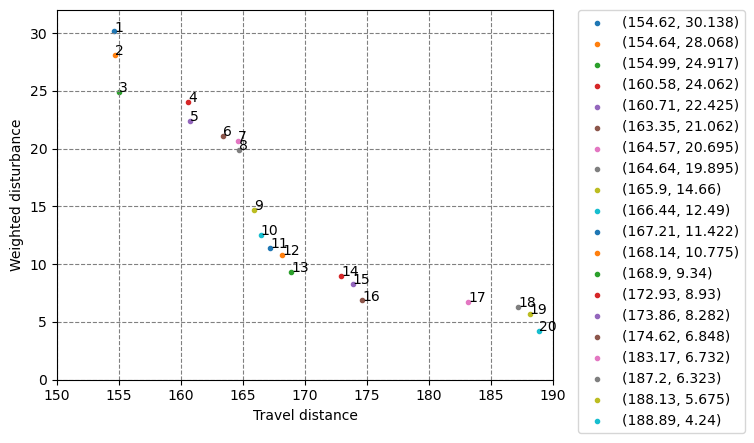

In [19]:
# Z1 : List[float]
Z1 = [sol[0] for sol in Liste_solutions_efficaces]
#Z2 : List[float]
Z2 = [sol[1] for sol in Liste_solutions_efficaces]

k = 1
for i, j in zip(Z1, Z2):
    plt.scatter(i, j, marker='.', label=str((i,j)))
    plt.annotate(str(k), (i, j))
    k += 1

plt.grid(linestyle='--', color='gray')
plt.xlim((150, 190)) 
plt.ylim((0.0, 32))

plt.xlabel('Travel distance')
plt.ylabel('Weighted disturbance')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)

<font color="blue">
  <div align="center">There are exactly</div>
</font>

<div align="center">6 supported solutions.</div>
<div align="justify">These are 1, 2, 3, 13, 16, 20</div>

Calculate the set of non-dominated solutions if we now limit the workload of each SR to the interval $[0.9, 1.1]$.

In [20]:
for cs in CHARGESUP.values():
    cs.RHS = 1.1
    
for ci in CHARGEINF.values():
    ci.RHS = 0.9

for e in EpsilonDict.values():
    m.remove(e)
    
m.update()

columns = ["Iteration", "First Objective", "Second Objective", "SR", "SR_OFFICE", "Bricks Allocated", "Workload", "Distance (km)"]
df_iterations = pd.DataFrame(columns=columns)

m.optimize()

it = 0
while m.status != GRB.INFEASIBLE:

    row = {
        "Iteration": it,
        "First Objective": round(m.objVal, 3),
        "Second Objective": round(z2.getValue(), 3)
    }

    for SR, BUREAU_SR, BRICKS in sr_assignments_current:
        row["SR"] = SR
        row["SR_OFFICE"] = SR_OFFICE
        row["Bricks Allocated"] = [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1]
        row["Workload"] = round(Charge[SR].getValue(), 3)
        row["Distance (km)"] = round(Distance[SR].getValue(), 3)

        df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)

    it += 1
    EpsilonDict[it] = m.addConstr(z2 <= z2.getValue() - epsilon, name=f'epsilon_{it}')
    m.update()
    m.optimize()

df_iterations

C:\Users\lucas\AppData\Local\Temp\ipykernel_17504\942549307.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)


,Iteration,First Objective,Second Objective,SR,SR_OFFICE,Bricks Allocated,Workload,Distance (km)
0,0,162.43,28.352,1,22,"[4, 5, 6, 7, 8, 9, 12, 19]",0.938,46.88
1,0,162.43,28.352,2,22,"[11, 13, 14, 17]",1.073,9.19
2,0,162.43,28.352,3,22,"[10, 15, 16, 18]",1.087,7.02
3,0,162.43,28.352,4,22,"[1, 2, 3, 20, 21, 22]",0.902,99.34
4,1,162.81,24.862,1,22,"[4, 5, 6, 7, 8, 9, 12, 19]",0.938,46.88
5,1,162.81,24.862,2,22,"[10, 14]",1.071,4.51
6,1,162.81,24.862,3,22,"[11, 13, 15, 16, 17, 18]",1.089,12.08
7,1,162.81,24.862,4,22,"[1, 2, 3, 20, 21, 22]",0.902,99.34
8,2,171.36,24.747,1,22,"[4, 5, 6, 7, 8, 9, 12, 20]",0.933,53.24
9,2,171.36,24.747,2,22,"[10, 14]",1.071,4.51


In [21]:
Distance_totale = df_iterations['First Objective'].to_list()
Pertubation_ponderee = df_iterations['Second Objective'].to_list()

solutions_efficaces = list(zip(Distance_totale, Pertubation_ponderee))
Liste_solutions_efficaces_q12 = list(OrderedDict.fromkeys(solutions_efficaces))
Liste_solutions_efficaces_q12

[(162.43, 28.352),
 (162.81, 24.862),
 (171.36, 24.747),
 (171.62, 12.168),
 (172.39, 11.1),
 (172.93, 8.93),
 (181.48, 8.815),
 (186.66, 8.492),
 (187.18, 8.393),
 (187.2, 6.323)]

Represent these solutions in bi-criteria space.

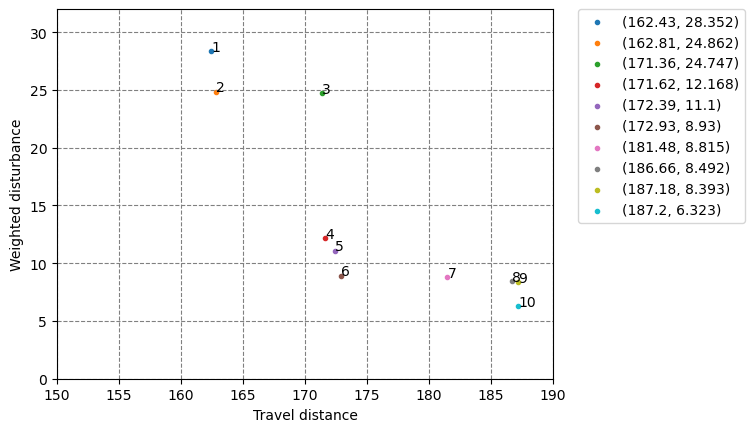

In [22]:
# Z1 : List[float]
Z1 = [sol[0] for sol in Liste_solutions_efficaces_q12]
#Z2 : List[float]
Z2 = [sol[1] for sol in Liste_solutions_efficaces_q12]

k = 1
for i, j in zip(Z1, Z2):
    plt.scatter(i, j, marker='.', label=str((i,j)))
    plt.annotate(str(k), (i, j))
    k += 1

plt.grid(linestyle='--', color='gray')
plt.xlim((150, 190)) 
plt.ylim((0.0, 32))

plt.xlabel('Travel distance')
plt.ylabel('Weighted disturbance')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)

Calculate the set of non-dominated solutions if we now limit the workload of each SR to the interval $[0.85, 1.15]$.

In [23]:
for cs in CHARGESUP.values():
    cs.RHS = 1.15
    
for ci in CHARGEINF.values():
    ci.RHS = 0.85

for e in EpsilonDict.values():
    m.remove(e)
    
m.update()

columns = ["Iteration", "First Objective", "Second Objective", "SR", "SR_OFFICE", "Bricks Allocated", "Workload", "Distance (km)"]
df_iterations = pd.DataFrame(columns=columns)

m.optimize()

it = 0
while m.status != GRB.INFEASIBLE:

    row = {
        "Iteration": it,
        "First Objective": round(m.objVal, 3),
        "Second Objective": round(z2.getValue(), 3)
    }

    for SR, BUREAU_SR, BRICKS in sr_assignments_current:
        row["SR"] = SR
        row["SR_OFFICE"] = SR_OFFICE
        row["Bricks Allocated"] = [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1]
        row["Workload"] = round(Charge[SR].getValue(), 3)
        row["Distance (km)"] = round(Distance[SR].getValue(), 3)

        df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)

    it += 1
    EpsilonDict[it] = m.addConstr(z2 <= z2.getValue() - epsilon, name=f'epsilon_{it}')
    m.update()
    m.optimize()

df_iterations

C:\Users\lucas\AppData\Local\Temp\ipykernel_17504\3950715657.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)


,Iteration,First Objective,Second Objective,SR,SR_OFFICE,Bricks Allocated,Workload,Distance (km)
0,0,160.34,27.645,1,22,"[4, 5, 6, 7, 8, 9, 12, 19]",0.938,46.88
1,0,160.34,27.645,2,22,"[11, 13, 14, 18]",1.045,7.56
2,0,160.34,27.645,3,22,"[10, 15, 16, 17]",1.115,6.56
3,0,160.34,27.645,4,22,"[1, 2, 3, 20, 21, 22]",0.902,99.34
4,1,160.36,25.575,1,22,"[4, 5, 6, 7, 8, 9, 19]",0.855,24.89
5,1,160.36,25.575,2,22,"[11, 12, 13, 14, 18]",1.127,29.57
6,1,160.36,25.575,3,22,"[10, 15, 16, 17]",1.115,6.56
7,1,160.36,25.575,4,22,"[1, 2, 3, 20, 21, 22]",0.902,99.34
8,2,162.81,24.862,1,22,"[4, 5, 6, 7, 8, 9, 12, 19]",0.938,46.88
9,2,162.81,24.862,2,22,"[10, 14]",1.071,4.51


In [24]:
Distance_totale = df_iterations['First Objective'].to_list()
Pertubation_ponderee = df_iterations['Second Objective'].to_list()

solutions_efficaces = list(zip(Distance_totale, Pertubation_ponderee))
Liste_solutions_efficaces_q12 = list(OrderedDict.fromkeys(solutions_efficaces))
Liste_solutions_efficaces_q12

[(160.34, 27.645),
 (160.36, 25.575),
 (162.81, 24.862),
 (169.11, 24.508),
 (171.6, 14.238),
 (171.62, 12.168),
 (172.14, 12.068),
 (172.16, 9.998),
 (172.93, 8.93),
 (181.48, 8.815),
 (186.43, 7.39),
 (187.2, 6.323)]

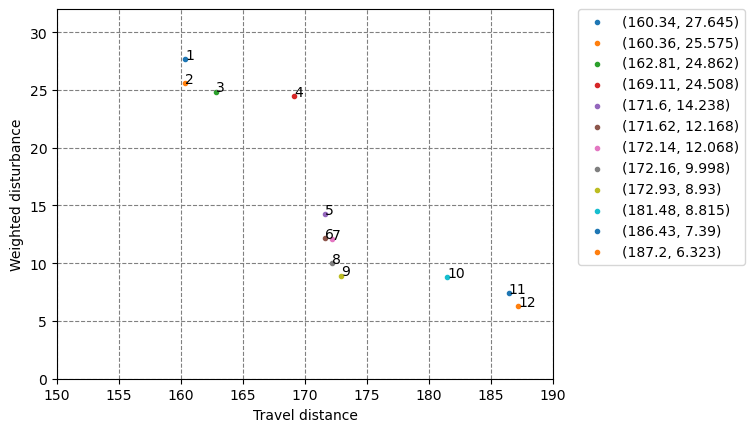

In [25]:
# Z1 : List[float]
Z1 = [sol[0] for sol in Liste_solutions_efficaces_q12]
#Z2 : List[float]
Z2 = [sol[1] for sol in Liste_solutions_efficaces_q12]

k = 1
for i, j in zip(Z1, Z2):
    plt.scatter(i, j, marker='.', label=str((i,j)))
    plt.annotate(str(k), (i, j))
    k += 1

plt.grid(linestyle='--', color='gray')
plt.xlim((150, 190)) 
plt.ylim((0.0, 32))

plt.xlabel('Travel distance')
plt.ylabel('Weighted disturbance')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)

## Scaling up the model
With 10 SRs and 100 zones 

- Visual representation of the solution in the decision space




In [26]:
column_names = [
    "zone", "x", "y", "workload_index", "current_office",
    "z1", "z2", "z3", "z4", "z5", "z6", "z7", "z8", "z9", "z10"
]

df = pd.read_csv(
    "Assets/Data/Pfitzer10-100.csv",
    skiprows=3,              # Skip the first 3 lines (including extra headers)
    names=column_names,      # Assign our known column names
    delimiter=";",           # Split columns on semicolons
    decimal=","              # Interpret commas as decimal points
)

# Convert columns to appropriate types
df["zone"] = df["zone"].astype(int)
df["x"] = df["x"].astype(float)
df["y"] = df["y"].astype(float)
df["workload_index"] = df["workload_index"].astype(float)
df["current_office"] = df["current_office"].astype(int)

# For the zone-membership columns (z1..z10), convert to integers
for zcol in column_names[5:]:
    df[zcol] = df[zcol].astype(int)

# (Optional) Add a unique brick identifier
df["brick_id"] = range(1, len(df) + 1)

# Now df contains the properly parsed data
df.head(10)

,zone,x,y,workload_index,current_office,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,brick_id
0,1,0.0137,0.0093,0.1602,0,1,0,0,0,0,0,0,0,0,0,1
1,2,0.1292,0.0351,0.1266,0,1,0,0,0,0,0,0,0,0,0,2
2,3,0.2587,0.0575,0.0011,1,1,0,0,0,0,0,0,0,0,0,3
3,4,0.3334,0.0589,0.1515,0,1,0,0,0,0,0,0,0,0,0,4
4,5,0.4490,0.0007,0.0318,0,0,1,0,0,0,0,0,0,0,0,5
5,6,0.5410,0.0258,0.0081,0,0,1,0,0,0,0,0,0,0,0,6
6,7,0.6560,0.0187,0.0739,0,0,1,0,0,0,0,0,0,0,0,7
7,8,0.7898,0.0186,0.0683,0,0,1,0,0,0,0,0,0,0,0,8
8,9,0.8902,0.0000,0.1562,0,0,1,0,0,0,0,0,0,0,0,9
9,10,0.9984,0.0147,0.0536,0,0,1,0,0,0,0,0,0,0,0,10


##  2. Extracting the Current Assignment and Office Locations

In [27]:
# Create a dictionary for the current assignment:
# current_assignment[(i, j)] = 1 if brick j is currently assigned to SR i, else 0.
current_assignment = {}
SRs = range(1, 11)  # SR IDs 1 through 10

for _, row in df.iterrows():
    j = int(row["brick_id"])
    # For each SR i, check if the corresponding zone membership (z{i}) is 1.
    for sr in SRs:
        # The column name for SR 'sr' is "z{sr}"
        current_assignment[(sr, j)] = 1 if row[f"z{sr}"] == 1 else 0

# Determine each SR's office coordinates.
# For each SR, select the first brick that is flagged as a current office and is a member of that SR's zone.
sr_office = {}
for sr in SRs:
    office_rows = df[(df["current_office"] == 1) & (df[f"z{sr}"] == 1)]
    if not office_rows.empty:
        office_brick = office_rows.iloc[0]
        sr_office[sr] = (office_brick["x"], office_brick["y"])
    else:
        raise ValueError(f"No office found for SR {sr}.")

print("Office locations (SR: (x, y)):")
sr_office


Office locations (SR: (x, y)):


{1: (0.2587, 0.0575),
 2: (0.7665, 0.1071),
 3: (0.9788, 0.2288),
 4: (0.2208, 0.3531),
 5: (0.8615, 0.5737),
 6: (0.1276, 0.8978),
 7: (0.2654, 0.7672),
 8: (0.5478, 0.6742),
 9: (0.8757, 0.7482),
 10: (0.7729, 0.9541)}

# 3. Computing the Distance Matrix

In [28]:
distance_sr_brick = {}
for sr in SRs:
    office_x, office_y = sr_office[sr]
    for _, row in df.iterrows():
        j = int(row["brick_id"])
        brick_x, brick_y = row["x"], row["y"]
        dist = np.sqrt((office_x - brick_x)**2 + (office_y - brick_y)**2)
        distance_sr_brick[(sr, j)] = dist

In [29]:
m = Model("Pfizer_assignment")

# Indices: bricks and SRs
bricks = df["brick_id"].tolist()  # Should be 1..100
# Decision variables: X[(i, j)] == 1 if brick j is assigned to SR i
X = {(i, j): m.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}") 
     for i in SRs for j in bricks}

m.update()

# Constraint 1: Each brick is assigned exactly once
for j in bricks:
    m.addConstr(quicksum(X[(i, j)] for i in SRs) == 1, name=f"Assign_{j}")

# Constraint 2: Workload balance for each SR.
# Define lower and upper bounds. (Adjust these as appropriate.)
# For example, if workloads are normalized, you might use 0.8 and 1.2.
Lmin = 0.8
Lmax = 1.2
workload_index = {int(row["brick_id"]): row["workload_index"] for _, row in df.iterrows()}

for i in SRs:
    m.addConstr(
        quicksum(X[(i, j)] * workload_index[j] for j in bricks) >= Lmin,
        name=f"Load_min_{i}"
    )
    m.addConstr(
        quicksum(X[(i, j)] * workload_index[j] for j in bricks) <= Lmax,
        name=f"Load_max_{i}"
    )

# Define the objectives

# Objective 1: Total travel distance
z1 = quicksum(X[(i, j)] * distance_sr_brick[(i, j)] for i in SRs for j in bricks)

# Objective 2: Weighted disturbance.
total_workload = sum(workload_index.values())
z2 = 100 * quicksum(
    workload_index[j] * (1 - current_assignment[(i, j)]) * X[(i, j)]
    for i in SRs for j in bricks
) / total_workload

# For example, start with the travel distance objective.
m.setObjective(z1, GRB.MINIMIZE)
m.params.outputflag = 0  # Set to 1 to see output if desired

m.update()
m.optimize()

print(f"Optimal total travel distance: {m.objVal:.3f}")

Optimal total travel distance: 15.000


# Visualizing the Results

. Spatial Map of Brick Assignments

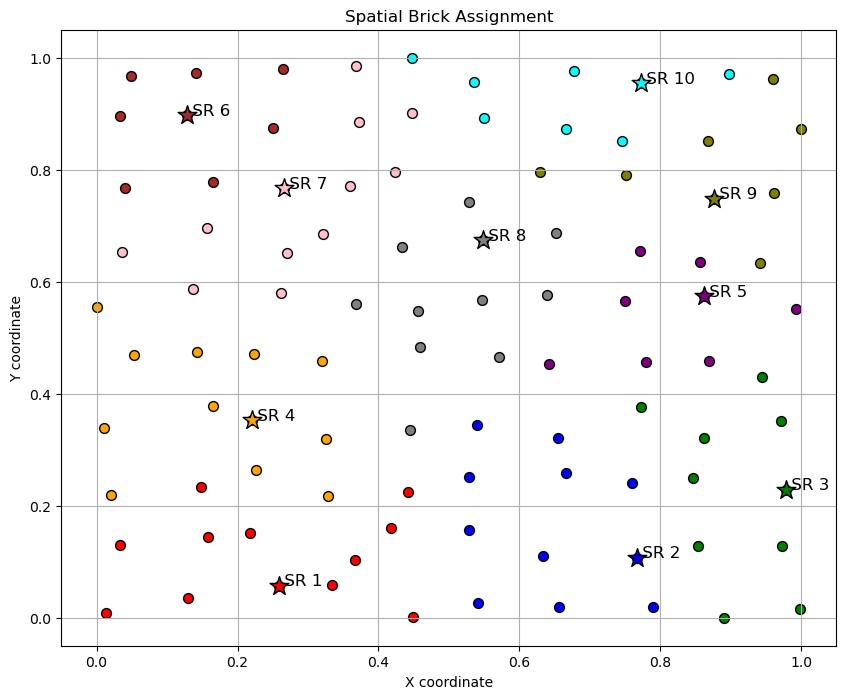

In [30]:
# Define colors for the 10 SRs (adjust or extend as needed)
colors = ['red', 'blue', 'green', 'orange', 'purple', 
          'brown', 'pink', 'gray', 'olive', 'cyan']

plt.figure(figsize=(10, 8))

# Plot each brick colored by its assigned SR.
for _, row in df.iterrows():
    j = int(row["brick_id"])
    assigned_sr = None
    for i in SRs:
        if X[(i, j)].x > 0.5:  # Use a threshold since the variable is binary
            assigned_sr = i
            break
    plt.scatter(row["x"], row["y"],
                color=colors[assigned_sr - 1],
                s=50, edgecolor='k')

# Plot the office locations with a star marker.
for sr in SRs:
    office_x, office_y = sr_office[sr]
    plt.scatter(office_x, office_y,
                color=colors[sr - 1],
                marker='*', s=200, edgecolor='k')
    plt.text(office_x, office_y, f" SR {sr}", fontsize=12)

plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Spatial Brick Assignment")
plt.grid(True)
plt.show()


## Step 2

Compute and represent the corresponding sets of non-dominated solution

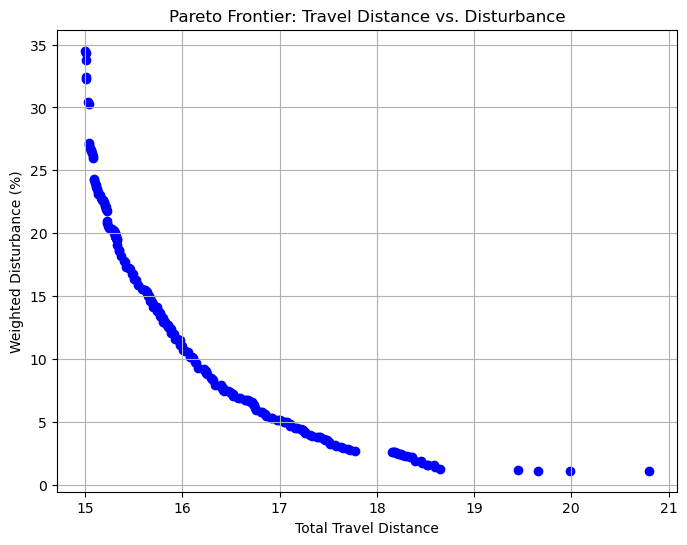

In [31]:
z1 = quicksum(X[(i, j)] * distance_sr_brick[(i, j)] for i in SRs for j in bricks)
z2 = 100 * quicksum(
    workload_index[j] * (1 - current_assignment[(i, j)]) * X[(i, j)]
    for i in SRs for j in bricks
) / total_workload

epsilon = 0.001
pareto_solutions = []
epsilon_constraints = {}
iteration = 0

# Minimize the travel distance first
m.setObjective(z1, GRB.MINIMIZE)
m.params.outputflag = 0
m.update()

while True:
    m.optimize()
    
    if m.status == GRB.OPTIMAL:
        current_z1 = m.objVal
        current_z2 = z2.getValue()
        pareto_solutions.append((current_z1, current_z2))
        #print(f"Iteration {iteration}: z1 = {current_z1:.3f}, z2 = {current_z2:.3f}")
        
        iteration += 1
        constr_name = f"epsilon_{iteration}"
        # Add a new constraint to force a strictly lower disturbance
        epsilon_constraints[iteration] = m.addConstr(z2 <= current_z2 - epsilon, name=constr_name)
        m.update()
    else:
        # If infeasible or no improvement, break.
        break

# Remove duplicates (preserving order)
unique_solutions = list(dict.fromkeys(pareto_solutions))

# Separate the objectives for plotting
Z1 = [sol[0] for sol in unique_solutions]
Z2 = [sol[1] for sol in unique_solutions]

# Plot the Pareto Frontier (no labels on the dots)
plt.figure(figsize=(8, 6))
plt.scatter(Z1, Z2, color='blue', marker='o')
plt.xlabel("Total Travel Distance")
plt.ylabel("Weighted Disturbance (%)")
plt.title("Pareto Frontier: Travel Distance vs. Disturbance")
plt.grid(True)
plt.show()


How to model the case for partially assigning bricks

In [32]:
column_names = [
    "zone", "x", "y", "workload_index", "current_office",
    "z1", "z2", "z3", "z4", "z5", "z6", "z7", "z8", "z9", "z10"
]

df = pd.read_csv(
    "Assets/Data/Pfitzer10-100.csv",
    skiprows=3,              # Skip the first 3 lines (including extra headers)
    names=column_names,      # Assign our known column names
    delimiter=";",           # Split columns on semicolons
    decimal=","              # Interpret commas as decimal points
)

# Convert columns to appropriate types
df["zone"] = df["zone"].astype(int)
df["x"] = df["x"].astype(float)
df["y"] = df["y"].astype(float)
df["workload_index"] = df["workload_index"].astype(float)
df["current_office"] = df["current_office"].astype(int)
for zcol in column_names[5:]:
    df[zcol] = df[zcol].astype(int)
df["brick_id"] = range(1, len(df) + 1)

# === Build Current Assignment and Office Locations ===
SRs = range(1, 11)  # 10 sales representatives

# Current assignment: for each brick, determine for each SR if that brick is assigned
current_assignment = {}
for _, row in df.iterrows():
    j = int(row["brick_id"])
    for sr in SRs:
        current_assignment[(sr, j)] = 1 if row[f"z{sr}"] == 1 else 0

# Determine each SR's office location (first brick where current_office==1 and zone membership for that SR)
sr_office = {}
for sr in SRs:
    office_rows = df[(df["current_office"] == 1) & (df[f"z{sr}"] == 1)]
    if not office_rows.empty:
        office_brick = office_rows.iloc[0]
        sr_office[sr] = (office_brick["x"], office_brick["y"])
    else:
        raise ValueError(f"No office found for SR {sr}.")

# Compute the Euclidean distance from each SR's office to each brick
distance_sr_brick = {}
for sr in SRs:
    office_x, office_y = sr_office[sr]
    for _, row in df.iterrows():
        j = int(row["brick_id"])
        brick_x, brick_y = row["x"], row["y"]
        distance_sr_brick[(sr, j)] = np.sqrt((office_x - brick_x)**2 + (office_y - brick_y)**2)

# Workload index for each brick
workload_index = {int(row["brick_id"]): row["workload_index"] for _, row in df.iterrows()}
total_workload = sum(workload_index.values())

# === Build the Optimization Model with Partial Assignment ===
m_partial = Model("PartialAssignment")
# Decision variables: allow fractional assignment x_{ij} in [0,1]
# (Note: in the previous model these were binary.)
bricks = df["brick_id"].tolist()  # list of brick IDs from 1 to 100
X_partial = {(i, j): m_partial.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name=f"x_{i}_{j}")
             for i in SRs for j in bricks}
m_partial.update()

# Constraint 1: Each brick's assignment fractions must sum to 1.
for j in bricks:
    m_partial.addConstr(quicksum(X_partial[(i, j)] for i in SRs) == 1, name=f"Assign_{j}")

# Constraint 2: Workload balance for each SR.
# (Using the same bounds as before; these can be adjusted.)
Lmin = 0.8
Lmax = 1.2
for i in SRs:
    m_partial.addConstr(
        quicksum(X_partial[(i, j)] * workload_index[j] for j in bricks) >= Lmin,
        name=f"Load_min_{i}"
    )
    m_partial.addConstr(
        quicksum(X_partial[(i, j)] * workload_index[j] for j in bricks) <= Lmax,
        name=f"Load_max_{i}"
    )

# Define the objectives (same as before)
z1_partial = quicksum(X_partial[(i, j)] * distance_sr_brick[(i, j)] for i in SRs for j in bricks)
z2_partial = 100 * quicksum(
    workload_index[j] * (1 - current_assignment[(i, j)]) * X_partial[(i, j)]
    for i in SRs for j in bricks
) / total_workload

# For demonstration, we start by minimizing travel distance.
m_partial.setObjective(z1_partial, GRB.MINIMIZE)
m_partial.params.outputflag = 0  # show solver output
m_partial.update()

m_partial.optimize()

print("----- Partial Assignment Model Results -----")
print(f"Optimal total travel distance: {m_partial.objVal:.3f}")
print(f"Corresponding weighted disturbance: {z2_partial.getValue():.3f} %")

----- Partial Assignment Model Results -----
Optimal total travel distance: 14.806
Corresponding weighted disturbance: 35.208 %


Visualizing the results

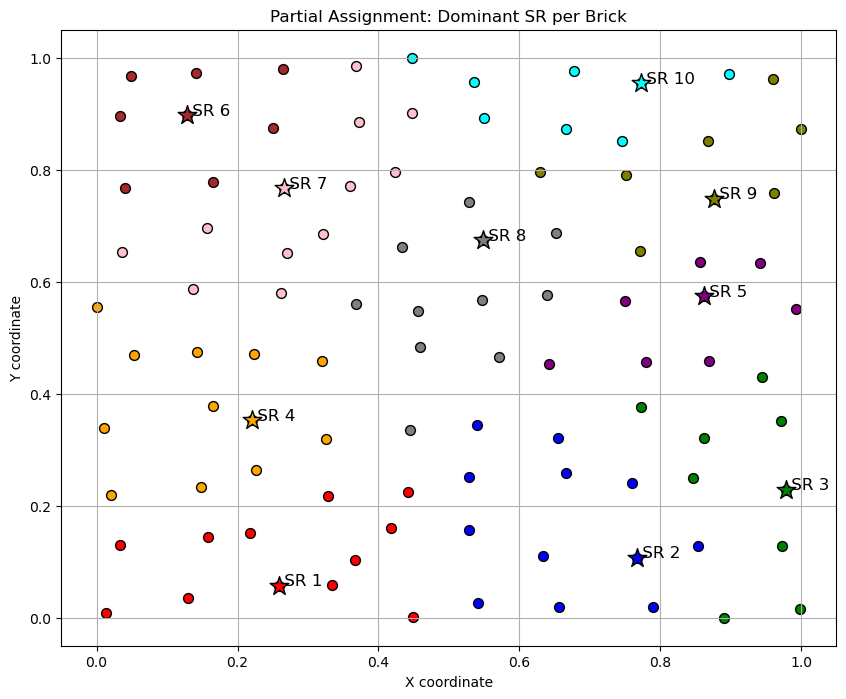

In [33]:
# Determine for each brick the SR with the highest assigned fraction in the partial model.
assigned_sr_partial = {}
for j in bricks:
    max_val = 0
    best_sr = None
    for i in SRs:
        val = X_partial[(i, j)].x
        if val > max_val:
            max_val = val
            best_sr = i
    assigned_sr_partial[j] = best_sr

colors = ['red', 'blue', 'green', 'orange', 'purple', 
          'brown', 'pink', 'gray', 'olive', 'cyan']

plt.figure(figsize=(10, 8))
for _, row in df.iterrows():
    j = int(row["brick_id"])
    sr = assigned_sr_partial[j]
    plt.scatter(row["x"], row["y"], color=colors[sr - 1], s=50, edgecolor='k')
    
# Also plot the office locations
for sr in SRs:
    office_x, office_y = sr_office[sr]
    plt.scatter(office_x, office_y, color=colors[sr - 1],
                marker='*', s=200, edgecolor='k')
    plt.text(office_x, office_y, f" SR {sr}", fontsize=12)

plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Partial Assignment: Dominant SR per Brick")
plt.grid(True)
plt.show()



--- Workloads for Each SR ---
SR 1 workload = 1.200
SR 2 workload = 1.183
SR 3 workload = 0.800
SR 4 workload = 1.200
SR 5 workload = 0.800
SR 6 workload = 0.817
SR 7 workload = 1.200
SR 8 workload = 1.200
SR 9 workload = 0.800
SR 10 workload = 0.800


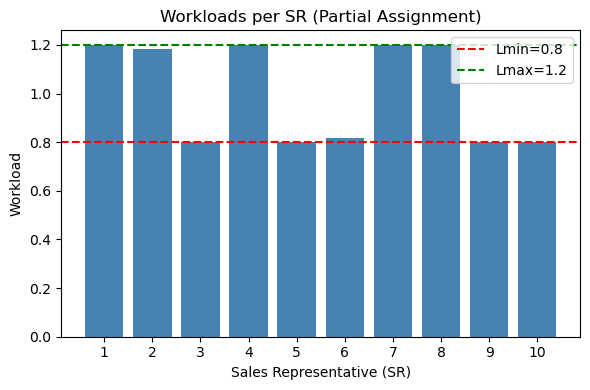

In [34]:
# After m_partial.optimize() has finished:

# 1. Compute each SR's total workload
workload_by_SR = {}
for i in SRs:
    sr_workload = sum(X_partial[(i, j)].X * workload_index[j] for j in bricks)
    workload_by_SR[i] = sr_workload

# 2. Print out workload results
print("\n--- Workloads for Each SR ---")
for i in SRs:
    print(f"SR {i} workload = {workload_by_SR[i]:.3f}")

# 3. (Optional) Visualize via a bar chart
plt.figure(figsize=(6,4))
plt.bar(workload_by_SR.keys(), workload_by_SR.values(), color='steelblue')
plt.axhline(y=Lmin, color='r', linestyle='--', label=f'Lmin={Lmin}')
plt.axhline(y=Lmax, color='g', linestyle='--', label=f'Lmax={Lmax}')
plt.title("Workloads per SR (Partial Assignment)")
plt.xlabel("Sales Representative (SR)")
plt.ylabel("Workload")
plt.xticks(list(SRs))
plt.legend()
plt.tight_layout()
plt.show()



If the demand increases uniformly in all bricks

Increase Demand and Prepare the Data

Loop Over Candidate Office Locations for the New SR

In [35]:
workload_index_new = {j: 1.25 * row["workload_index"]
                      for j, row in df.set_index("brick_id").iterrows()}
total_workload_new = sum(workload_index_new.values())

Lmin = 0.8
Lmax = 1.2

# Original SRs (1 to 10) have fixed office locations in sr_office (assumed computed earlier)
# List of all brick IDs
bricks = df["brick_id"].tolist()

# To store candidate results: (candidate brick id, x, y, objective value)
candidate_results = []

best_obj = float('inf')
best_candidate = None

# Loop over candidate bricks for the new SR's office
for candidate in bricks:
    # Get candidate coordinates from df
    candidate_row = df.loc[df["brick_id"] == candidate].iloc[0]
    candidate_x = candidate_row["x"]
    candidate_y = candidate_row["y"]
    
    # Build new SR office dictionary for 11 SRs:
    sr_office_new = sr_office.copy()  # original 10 SRs (fixed)
    sr_office_new[11] = (candidate_x, candidate_y)  # new candidate for SR 11
    
    # Build the assignment model for 11 SRs.
    m_new = Model("Assignment_with_new_SR")
    SRs_new = list(range(1, 12))  # 1 to 11
    # Decision variables: binary variables x_{ij} (brick j assigned to SR i)
    X_new = {(i, j): m_new.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")
             for i in SRs_new for j in bricks}
    m_new.update()
    
    # Constraint: each brick must be assigned exactly once.
    for j in bricks:
        m_new.addConstr(quicksum(X_new[(i, j)] for i in SRs_new) == 1, name=f"Assign_{j}")
    
    # Workload balance for each SR using the increased workloads:
    for i in SRs_new:
        m_new.addConstr(
            quicksum(X_new[(i, j)] * workload_index_new[j] for j in bricks) >= Lmin,
            name=f"Load_min_{i}"
        )
        m_new.addConstr(
            quicksum(X_new[(i, j)] * workload_index_new[j] for j in bricks) <= Lmax,
            name=f"Load_max_{i}"
        )
    
    # Compute the distance from each SR’s office to each brick.
    distance_new = {}
    for i in SRs_new:
        office_x, office_y = sr_office_new[i]
        for j in bricks:
            # Retrieve brick coordinates
            row = df.loc[df["brick_id"] == j].iloc[0]
            brick_x, brick_y = row["x"], row["y"]
            distance_new[(i, j)] = math.sqrt((office_x - brick_x)**2 + (office_y - brick_y)**2)
    
    # Define the objective: total travel distance over all assignments.
    z1_new = quicksum(X_new[(i, j)] * distance_new[(i, j)] for i in SRs_new for j in bricks)
    m_new.setObjective(z1_new, GRB.MINIMIZE)
    m_new.params.outputflag = 0  # set to 1 to display solver output
    m_new.update()
    
    m_new.optimize()
    
    if m_new.status == GRB.OPTIMAL:
        obj_val = m_new.objVal
        candidate_results.append((candidate, candidate_x, candidate_y, obj_val))
        if obj_val < best_obj:
            best_obj = obj_val
            best_candidate = candidate
    else:
        candidate_results.append((candidate, candidate_x, candidate_y, None))
    
# Display the best candidate
print("Best candidate for new office (brick id):", best_candidate)
best_coords = df.loc[df["brick_id"]==best_candidate, ["x", "y"]].values[0]
print("Coordinates of best candidate:", best_coords)
print("Objective value (total travel distance):", best_obj)


Best candidate for new office (brick id): 25
Coordinates of best candidate: [0.4423 0.2249]
Objective value (total travel distance): 14.240074566198011


Compare and Visualize

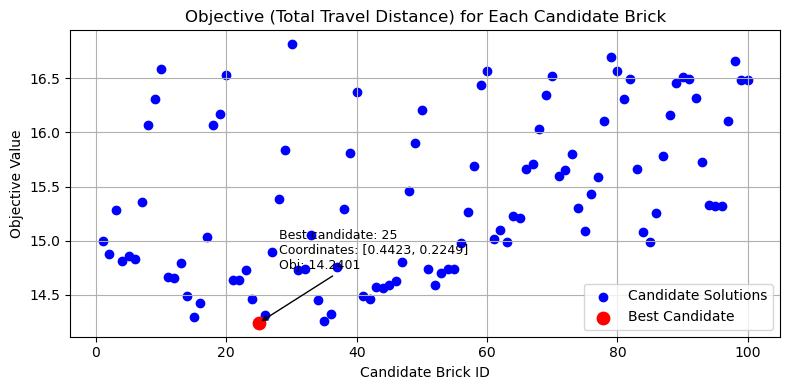

In [36]:
# `candidate_results` is a list of tuples (candidate, candidate_x, candidate_y, obj_val)
# `best_candidate` is the ID of the best candidate brick
# `best_coords` is [x, y] for that best candidate
# `best_obj` is the minimal objective found.

# Extract only candidates that solved successfully (obj_val != None)
cand_ids = []
cand_objs = []
for (c_id, c_x, c_y, c_obj) in candidate_results:
    if c_obj is not None:
        cand_ids.append(c_id)
        cand_objs.append(c_obj)

# Plot the objective vs. candidate ID
plt.figure(figsize=(8, 4))
plt.scatter(cand_ids, cand_objs, color='blue', label='Candidate Solutions')

# Highlight the best candidate in red
plt.scatter(best_candidate, best_obj, color='red', s=80, label='Best Candidate')

plt.title("Objective (Total Travel Distance) for Each Candidate Brick")
plt.xlabel("Candidate Brick ID")
plt.ylabel("Objective Value")
plt.legend()
plt.grid(True)

# Annotate the best candidate
annotation_text = (
    f"Best candidate: {best_candidate}\n"
    f"Coordinates: [{best_coords[0]:.4f}, {best_coords[1]:.4f}]\n"
    f"Obj: {best_obj:.4f}"
)
plt.annotate(
    annotation_text,
    xy=(best_candidate, best_obj),
    xytext=(best_candidate+3, best_obj+0.5),  # shift label to avoid overlapping the point
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=9
)

plt.tight_layout()
plt.show()


Best candidate for new office (brick id): 25
Coordinates of best candidate: [0.4423 0.2249]
Objective value (total travel distance): 14.240074566198011

--- Final model objective with 11 SRs ---
Objective (total travel distance): 14.2401

--- Updated Workloads for SRs 1..11 ---
SR 1: 1.122
SR 2: 1.169
SR 3: 0.818
SR 4: 1.197
SR 5: 1.166
SR 6: 1.181
SR 7: 1.178
SR 8: 1.200
SR 9: 1.138
SR 10: 1.179
SR 11: 1.153


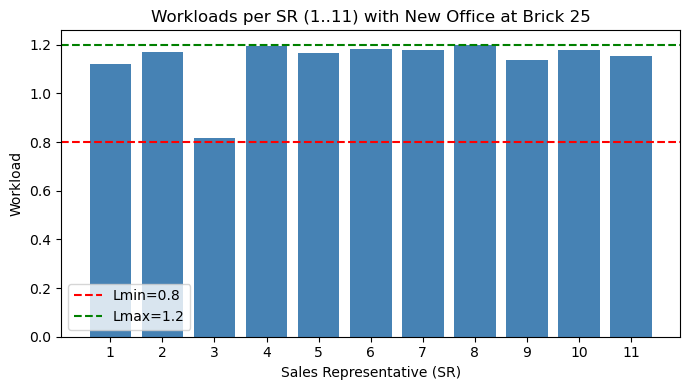

In [37]:
print("Best candidate for new office (brick id):", best_candidate)
best_coords = df.loc[df["brick_id"] == best_candidate, ["x", "y"]].values[0]
candidate_x, candidate_y = best_coords
print("Coordinates of best candidate:", best_coords)
print("Objective value (total travel distance):", best_obj)

# -----------------------------
# 2) BUILD A FINAL MODEL WITH THE NEW SR #11 AT THE BEST CANDIDATE
sr_office_final = sr_office.copy()  # your existing SR office dict for SRs 1..10
sr_office_final[11] = (candidate_x, candidate_y)  # place SR 11 at best candidate

m_final = Model("Assignment_with_best_new_SR")
SRs_11 = list(range(1, 12))  # SRs 1..11
bricks = df["brick_id"].tolist()  # all bricks

# Binary decision variables: x_{i,j} = 1 if brick j assigned to SR i
X_final = {
    (i, j): m_final.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")
    for i in SRs_11 for j in bricks
}
m_final.update()

# Each brick assigned exactly once
for j in bricks:
    m_final.addConstr(quicksum(X_final[(i, j)] for i in SRs_11) == 1, name=f"Assign_{j}")

# Same workload constraints with Lmin, Lmax
Lmin = 0.8
Lmax = 1.2
for i in SRs_11:
    m_final.addConstr(
        quicksum(X_final[(i, j)] * workload_index_new[j] for j in bricks) >= Lmin,
        name=f"Load_min_{i}"
    )
    m_final.addConstr(
        quicksum(X_final[(i, j)] * workload_index_new[j] for j in bricks) <= Lmax,
        name=f"Load_max_{i}"
    )

# Distance calc from office i to brick j
distance_new = {}
for i in SRs_11:
    office_x, office_y = sr_office_final[i]
    for j in bricks:
        row = df.loc[df["brick_id"] == j].iloc[0]
        brick_x, brick_y = row["x"], row["y"]
        distance_new[(i, j)] = math.sqrt((office_x - brick_x)**2 + (office_y - brick_y)**2)

# Objective: minimize total travel distance
z1_new = quicksum(X_final[(i, j)] * distance_new[(i, j)] for i in SRs_11 for j in bricks)
m_final.setObjective(z1_new, GRB.MINIMIZE)
m_final.params.outputflag = 0
m_final.update()
m_final.optimize()

if m_final.status == GRB.OPTIMAL:
    print(f"\n--- Final model objective with 11 SRs ---")
    print(f"Objective (total travel distance): {m_final.objVal:.4f}\n")
else:
    print("Model not optimal or infeasible.")

# -----------------------------
# 3) COMPUTE THE UPDATED WORKLOADS AND PLOT
workload_by_SR_11 = {}
for i in SRs_11:
    sr_load = sum(X_final[(i, j)].X * workload_index_new[j] for j in bricks)
    workload_by_SR_11[i] = sr_load

print("--- Updated Workloads for SRs 1..11 ---")
for i in SRs_11:
    print(f"SR {i}: {workload_by_SR_11[i]:.3f}")

# 4) BAR CHART
plt.figure(figsize=(7,4))
plt.bar(workload_by_SR_11.keys(), workload_by_SR_11.values(), color='steelblue')

# Draw reference lines for Lmin, Lmax
plt.axhline(y=Lmin, color='r', linestyle='--', label=f'Lmin={Lmin}')
plt.axhline(y=Lmax, color='g', linestyle='--', label=f'Lmax={Lmax}')

plt.title("Workloads per SR (1..11) with New Office at Brick " + str(best_candidate))
plt.xlabel("Sales Representative (SR)")
plt.ylabel("Workload")
plt.xticks(SRs_11)
plt.legend()
plt.tight_layout()
plt.show()


# Step 3: 
The location of the “center bricks” (SR offices) has a significant impact on the distance traveled by the
sales representatives. An important question is to generalize the model to allow a modification of the
“center bricks”.

## **Exercise**: 
Formulate a bi-objective optimization problem in which positions of offices are variables and in which the two objectives are the total distance (min), and the workload of SRs (MinMax).

### Bi-Objective Territory Assignment Model

When choosing **both** the **positions of centers** (offices) for Sales Representatives (SRs) *and* how bricks are assigned to these SRs, we can formulate a **bi-objective** problem with:
1. **Minimization of Total Distance**  
2. **Minimization of Workload Imbalance (MinMax)**

---

### Sets and Parameters

- **$S$**: Set of Sales Representatives, indexed by $i$.  
- **$B$**: Set of Bricks, indexed by $j$.  
- **$D_{k,j}$**: Distance between Brick $k$ and Brick $j$.  
- **$W_j$**: Workload of Brick $j$.

---

### Decision Variables

1. **$x_{i,j} \in \{0,1\}$**  
   Indicates whether Brick $j$ is assigned to SR $i$.  
   - $x_{i,j} = 1$ if Brick $j$ is assigned to SR $i$.  
   - $x_{i,j} = 0$ otherwise.

2. **$c_{k,i} \in \{0,1\}$**  
   Indicates whether Brick $k$ is **the center** for SR $i$.  
   - $c_{k,i} = 1$ if Brick $k$ is the center of SR $i$.  
   - $c_{k,i} = 0$ otherwise.  
   By constraining exactly one center per SR, each SR chooses exactly one Brick to be its office location.

3. **Workload Bounds**  
   - $\text{max\_workload}\ \ge 0$  
   - $\text{min\_workload}\ \ge 0$  
   These two real variables capture the maximum and minimum workload among all SRs.

---

### Objective Functions

#### Objective 1: Minimize Total Distance

We consider the distance between each **brick** $j$ and the **center** $k$ of the SR $i$. A direct representation is:

$$
\min \sum_{i \in S} \sum_{j \in B} \sum_{k \in B} 
\Bigl( D_{k,j} \cdot x_{i,j} \cdot c_{k,i} \Bigr).
$$

- $D_{k,j}$ is the distance from Brick $k$ (candidate center) to Brick $j$.  
- $x_{i,j} = 1$ if Brick $j$ is assigned to SR $i$.  
- $c_{k,i} = 1$ if Brick $k$ is the center for SR $i$.  

Hence, distance $D_{k,j}$ is added **only** when SR $i$ has $k$ as center *and* Brick $j$ is assigned to SR $i$.

#### Objective 2: Minimize Workload Imbalance (MinMax)

We want to **balance** the workloads across SRs. Define:

- $\text{max\_workload}$ = largest workload among all SRs,  
- $\text{min\_workload}$ = smallest workload among all SRs.

We minimize:

$$
\min \ \text{max\_workload} \;-\; \text{min\_workload}.
$$

This forces the heaviest-loaded SR and the lightest-loaded SR to be closer in total workload, improving balance.

---

### Constraints

1. **Unique Assignment**  
   Each Brick $j$ is assigned to **exactly one** SR:

   $$
   \sum_{i \in S} x_{i,j} = 1, 
   \quad \forall j \in B.
   $$

2. **Exactly One Center per SR**  
   Each SR $i$ chooses **exactly one** Brick as its center:

   $$
   \sum_{k \in B} c_{k,i} = 1, 
   \quad \forall i \in S.
   $$

3. **Link Between Assignment and Having a Center**  
   A Brick $j$ can only be assigned to SR $i$ if SR $i$ has a center. Often we simply do:

   $$
   x_{i,j} \;\le\; \sum_{k \in B} c_{k,i}, 
   \quad \forall i \in S, \; \forall j \in B.
   $$
   
   Since $\sum_{k \in B} c_{k,i} = 1$ in principle, this ensures $x_{i,j}$ is allowed only if SR $i$ chose some center.

4. **Workload Bounds**  
   Let the workload of SR $i$ be 
   $\text{Workload}_i = \sum_{j \in B} W_j \, x_{i,j}.$

   We then impose:

   $$
   \text{max\_workload} \;\;\ge\;\; \text{Workload}_i,
   \quad \forall i \in S,
   $$

   $$
   \text{min\_workload} \;\;\le\;\; \text{Workload}_i,
   \quad \forall i \in S.
   $$

Minimizing $\text{max\_workload} - \text{min\_workload}$ tries to keep $\text{Workload}_i$ consistent across all SRs.

---

### Linearization Process

Guorbi solver only supports linear equations, which is not the case for $(x_{i,j} \cdot c_{k,i})$. Now, let's linearize the problem:

1. **Introduce** an additional binary variable, say $y_{i,j,k}$, such that  
   $$
   y_{i,j,k} \;=\; x_{i,j} \,\times\, c_{k,i}.
   $$

2. **Add** the following constraints for all $(i,j,k)$:
   $$
   \begin{cases}
   y_{i,j,k} \;\le\; x_{i,j},\\
   y_{i,j,k} \;\le\; c_{k,i},\\
   y_{i,j,k} \;\ge\; x_{i,j} + c_{k,i} - 1.
   \end{cases}
   $$

3. **Replace** in the objective function, using $y_{i,j,k}$ instead of $(x_{i,j} \cdot c_{k,i})$:
   $$
   \text{Distance Objective} \;=\;
   \sum_{i \in S} \sum_{j \in B} \sum_{k \in B} D_{k,j} \,y_{i,j,k}.
   $$

This ensures that $y_{i,j,k} = 1$ **only** if both $x_{i,j}$ and $c_{k,i}$ are 1, and 0 otherwise, preserving the meaning of the original product.

• Formulate a bi-objective optimization problem in which positions of offices are variables and in
which the two objectives are the total distance (min), and the workload of SRs (MinMax),

In [ ]:
# --------------------------
# Problem Data
# --------------------------

# Sets
bricks = list(range(0, 22))  # 22 bricks
srs = list(range(1, 6))      # 5 Sales Representatives (SRs)

# Workload simulation
brick_workload = {j: np.random.uniform(0.05, 0.8) for j in bricks}  # Workload for each brick

# Distance matrix (22x22) - simulated values
D = np.random.randint(5, 50, (22, 22))

# --------------------------
# Optimization Model
# --------------------------

model = Model("Territory_Optimization")

# Decision variables
# x[i,j] = 1 if Brick j is assigned to SR i
x = model.addVars(srs, bricks, vtype=GRB.BINARY, name="Assign")

# c[j,i] = 1 if Brick j is chosen as the center for SR i
c = model.addVars(bricks, srs, vtype=GRB.BINARY, name="Center")

# d[i,j] = a continuous variable representing the actual distance
# from brick j to SR i's center
d = model.addVars(srs, bricks, vtype=GRB.CONTINUOUS, name="Distance")

# Auxiliary variables to minimize the workload difference
max_workload = model.addVar(name="MaxWorkload")
min_workload = model.addVar(name="MinWorkload")

# --------------------------
# Linearization Variables: y[i,j,k]
# y[i,j,k] = x[i,j] * c[k,i]
# i = SR index
# j = brick assigned to SR
# k = the brick potentially serving as SR's center
# --------------------------
y = model.addVars(srs, bricks, bricks, vtype=GRB.BINARY, name="Y")

# Linearization constraints:
for i in srs:
    for j in bricks:       # assigned brick
        for k in bricks:   # possible center
            model.addConstr(y[i, j, k] <= x[i, j],
                             name=f"Lin_Y_le_X_{i}_{j}_{k}")
            model.addConstr(y[i, j, k] <= c[k, i],
                             name=f"Lin_Y_le_C_{i}_{j}_{k}")
            model.addConstr(y[i, j, k] >= x[i, j] + c[k, i] - 1,
                             name=f"Lin_Y_ge_XplusC_{i}_{j}_{k}")

# --------------------------
# Objective 1: Minimize Total Distance
# --------------------------
#
# We want d[i,j] >= the sum of distances from brick j to k,
# weighted by y[i,j,k]. If y[i,j,k] = 1, that means
# (j is assigned to i) AND (k is the center for i).
#
for i in srs:
    for j in bricks:
        model.addConstr(
            d[i, j] >= quicksum(D[j, k] * y[i, j, k] for k in bricks),
            name=f"DistCalc_{i}_{j}"
        )

# The objective function is the total sum of d[i,j].
model.setObjectiveN(
    quicksum(d[i, j] for i in srs for j in bricks),
    index=0, priority=1
)

# --------------------------
# Objective 2: Minimize the Maximum Workload Difference
# --------------------------

# Calculate the workload for each SR i
workloads = {}
for i in srs:
    workloads[i] = quicksum(brick_workload[j] * x[i, j] for j in bricks)

# Constraints for max_workload and min_workload
for i in srs:
    model.addConstr(max_workload >= workloads[i], name=f"Max_Workload_{i}")
    model.addConstr(min_workload <= workloads[i], name=f"Min_Workload_{i}")

# Minimize (max_workload - min_workload)
model.setObjectiveN(
    max_workload - min_workload,
    index=1, priority=0
)

# --------------------------
# Constraints
# --------------------------

# 1. Each brick must be assigned to exactly one SR
for j in bricks:
    model.addConstr(
        quicksum(x[i, j] for i in srs) == 1,
        name=f"UniqueAssignment_{j}"
    )

# 2. Each SR must have exactly one center
for i in srs:
    model.addConstr(
        quicksum(c[j, i] for j in bricks) == 1,
        name=f"OneCenter_{i}"
    )

# 3. A brick can only be assigned if this SR has a center
for i in srs:
    for j in bricks:
        # x[i,j] <= sum(c[k,i]) for k in bricks
        # This is typically always =1 anyway since sum(c[k,i])=1, but kept for completeness
        model.addConstr(
            x[i, j] <= quicksum(c[k, i] for k in bricks),
            name=f"AssignToCenter_{i}_{j}"
        )

# --------------------------
# Solve the Model
# --------------------------
model.optimize()

# --------------------------
# Display the Solution
# --------------------------
if model.status == GRB.OPTIMAL:
    print("\nOptimal Solution Found!")
    
    print("Chosen Centers for each SR:")
    for i in srs:
        center_brick = [j for j in bricks if c[j, i].x > 0.5]
        print(f"SR {i}: Center {center_brick}")

    print("\nAssignment of Bricks to SRs:")
    for i in srs:
        assigned_bricks = [j for j in bricks if x[i, j].x > 0.5]
        print(f"SR {i}: Bricks {assigned_bricks}")

    print("\nMaximum Workload Difference:", max_workload.x - min_workload.x)
else:
    print("\nNo optimal solution found.")

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1235U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 7517 rows, 2752 columns and 22450 nonzeros
Model fingerprint: 0xf4e1ceab
Variable types: 112 continuous, 2640 integer (2640 binary)
Coefficient statistics:
  Matrix range     [2e-01, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 110 rows and 0 columns
Presolve time: 0.09s
Presolved: 7407 rows, 2752 columns, 199

In this context of possibly modified center bricks, the disruption is redefined in terms of the number
of relocated offices (without any consideration of the changes in the assignment of bricks to SRs). As
this new disruption formulation (number of relocated offices) takes integer values in [0, number of
SRs], compute the sets of non-dominated solutions for the three-objective problem (total distance,
workload fairness, and number of relocated offices)

Baseline centers: {1: 9, 2: 15, 3: 13, 4: 1}

Non-dominated solutions (Total Distance, Maximum Workload, Disruption):
  Z1 = 500.9810,   T = 2.0000,   D = 0
  Z1 = 500.9810,   T = 1.9900,   D = 0
  Z1 = 500.9810,   T = 1.9800,   D = 0
  Z1 = 500.9810,   T = 1.9700,   D = 0
  Z1 = 500.9810,   T = 1.9600,   D = 0
  Z1 = 500.9810,   T = 1.9500,   D = 0
  Z1 = 500.9810,   T = 1.9400,   D = 0
  Z1 = 500.9810,   T = 1.9300,   D = 0
  Z1 = 500.9810,   T = 1.9200,   D = 0
  Z1 = 500.9810,   T = 1.9100,   D = 0
  Z1 = 500.9810,   T = 1.9000,   D = 0
  Z1 = 500.9810,   T = 1.8900,   D = 0
  Z1 = 500.9810,   T = 1.8800,   D = 0
  Z1 = 500.9810,   T = 1.8700,   D = 0
  Z1 = 500.9810,   T = 1.8600,   D = 0
  Z1 = 500.9810,   T = 1.8500,   D = 0
  Z1 = 500.9810,   T = 1.8400,   D = 0
  Z1 = 500.9810,   T = 1.8300,   D = 0
  Z1 = 500.9810,   T = 1.8200,   D = 0
  Z1 = 500.9810,   T = 1.8100,   D = 0
  Z1 = 500.9810,   T = 1.8000,   D = 0
  Z1 = 402.1574,   T = 2.0000,   D = 1
  Z1 = 402.1574,   T = 1

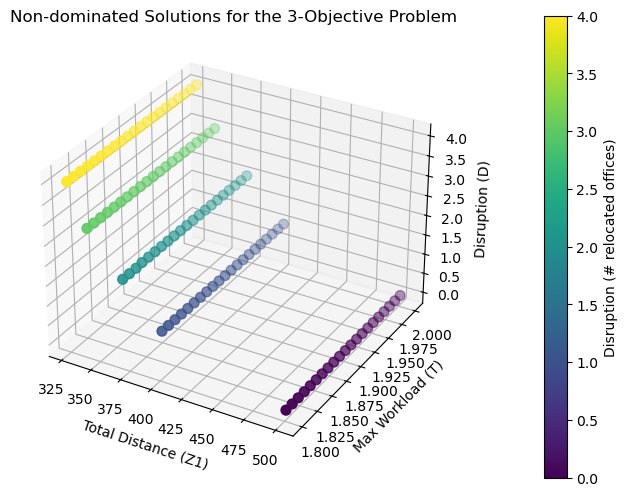

In [39]:
# -------------------------------
# 1. DATA
# -------------------------------
np.random.seed(42)

num_bricks = 22
num_sr = 4
I = range(1, num_sr+1)
J = range(1, num_bricks+1)

# Generate synthetic brick coordinates (for facility locations and distances)
brick_coords = {
    j: (np.random.uniform(0,100), np.random.uniform(0,100)) 
    for j in J
}

# Generate synthetic workloads for bricks
raw_workloads = np.random.uniform(0.5, 1.5, num_bricks)
total_raw = np.sum(raw_workloads)
# Normalize so that the sum of w[j] across j equals num_sr
# so that the average workload per SR would be around 1
w = { j: (raw_workloads[j-1] / total_raw) * num_sr for j in J }

# Precompute distances d[(k,j)] = distance from brick k to brick j
d = {}
for k in J:
    for j in J:
        ax, ay = brick_coords[k]
        bx, by = brick_coords[j]
        d[(k,j)] = np.hypot(ax - bx, ay - by)

# Assume we have a baseline center for each SR (e.g., from a previous solution)
# Here, we randomly select a baseline brick for each SR
baseline = {}
for i in I:
    baseline[i] = np.random.choice(list(J))
print("Baseline centers:", baseline)

# -------------------------------
# 2. MODEL DEFINITION
# -------------------------------
model = Model("ThreeObj_Assignment")

# Turn solver output off:
model.Params.OutputFlag = 0

# Optional: set a time limit per subproblem (in seconds)
model.Params.TimeLimit = 60

# Variables:
#   x[i,j]: 1 if brick j is assigned to SR i
x = {}
for i in I:
    for j in J:
        x[(i,j)] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")

#   y[i,k]: 1 if SR i chooses brick k as its office
y = {}
for i in I:
    for k in J:
        y[(i,k)] = model.addVar(vtype=GRB.BINARY, name=f"y_{i}_{k}")

#   z[i,j,k]: linking variable for distance (1 if j is assigned to i AND i's center is k)
z = {}
for i in I:
    for j in J:
        for k in J:
            z[(i,j,k)] = model.addVar(vtype=GRB.BINARY, name=f"z_{i}_{j}_{k}")

#   T_var: continuous variable for max workload
T_var = model.addVar(vtype=GRB.CONTINUOUS, lb=0, name="T")

model.update()

# -------------------------------
# 3. CONSTRAINTS
# -------------------------------
# (a) Each brick must be assigned to exactly one SR
for j in J:
    model.addConstr(quicksum(x[(i,j)] for i in I) == 1, name=f"AssignBrick_{j}")

# (b) Each SR must choose exactly one office
for i in I:
    model.addConstr(quicksum(y[(i,k)] for k in J) == 1, name=f"ChooseCenter_{i}")

# (c) Linking constraints between x, y, z
for i in I:
    for j in J:
        model.addConstr(quicksum(z[(i,j,k)] for k in J) == x[(i,j)], name=f"Link_x_{i}_{j}")
        for k in J:
            model.addConstr(z[(i,j,k)] <= y[(i,k)], name=f"Link_y_{i}_{j}_{k}")
            model.addConstr(z[(i,j,k)] <= x[(i,j)], name=f"Link_x2_{i}_{j}_{k}")
            model.addConstr(z[(i,j,k)] >= x[(i,j)] + y[(i,k)] - 1, name=f"Link_xy_{i}_{j}_{k}")

# (d) Workload constraints: sum of assigned workloads for each SR <= T_var
for i in I:
    model.addConstr(quicksum(w[j] * x[(i,j)] for j in J) <= T_var, name=f"Workload_{i}")

# (e) Disruption expression
# Disruption = number of SRs whose chosen center != baseline[i]
def disruption_expr():
    # sum_{i in I} sum_{k != baseline[i]} y[i,k]
    return quicksum(y[(i,k)] 
                    for i in I 
                    for k in J if k != baseline[i])

# -------------------------------
# 4. OBJECTIVE FUNCTION COMPONENTS
# -------------------------------
#  Z1: total travel distance
Z1 = quicksum(d[(k,j)] * z[(i,j,k)] for i in I for j in J for k in J)
#  T: maximum workload (T_var)
#  D: disruption_expr()

# We'll use the epsilon-constraint method below, so we won't set a single objective here yet.

model.update()

# -------------------------------
# 5. COMPUTING NON-DOMINATED SOLUTIONS VIA EPSILON-CONSTRAINT
# -------------------------------
non_dominated = []

# Epsilon step (increase if you want fewer iterations)
epsilon = 0.01
# Max number of times we'll tighten T before moving on
max_epsilon_iterations = 20

# For each disruption level d_target in [0..num_sr]
for d_target in range(num_sr+1):
    # Add constraint: disruption_expr() == d_target
    d_constr = model.addConstr(disruption_expr() == d_target, name=f"Disruption_eq_{d_target}")
    model.update()

    # (A) First, solve with no bound on T (just minimize Z1)
    model.setObjective(Z1, GRB.MINIMIZE)
    model.update()
    model.optimize()

    if model.status == GRB.OPTIMAL:
        # Record the solution
        best_Z1 = model.objVal
        best_T = T_var.X
        non_dominated.append((best_Z1, best_T, d_target))

        # Now iteratively tighten T
        iteration_count = 0
        while iteration_count < max_epsilon_iterations:
            # Add T <= best_T - epsilon
            eps_constr = model.addConstr(T_var <= best_T - epsilon, name=f"eps_{d_target}_{iteration_count}")
            model.update()
            model.optimize()

            if model.status == GRB.OPTIMAL:
                new_Z1 = model.objVal
                new_T  = T_var.X
                # Record only if T improved
                if new_T < best_T - 1e-9:
                    best_Z1 = new_Z1
                    best_T  = new_T
                    non_dominated.append((best_Z1, best_T, d_target))
                    iteration_count += 1
                    # Remove constraint before next iteration
                    model.remove(eps_constr)
                    model.update()
                else:
                    # No real improvement in T
                    model.remove(eps_constr)
                    model.update()
                    break
            else:
                # Infeasible or not optimal
                model.remove(eps_constr)
                model.update()
                break

    # Remove the disruption constraint for next d_target
    model.remove(d_constr)
    model.update()

# -------------------------------
# 6. OUTPUT RESULTS
# -------------------------------
print("\nNon-dominated solutions (Total Distance, Maximum Workload, Disruption):")
for (val_Z1, val_T, val_D) in non_dominated:
    print(f"  Z1 = {val_Z1:.4f},   T = {val_T:.4f},   D = {val_D}")

# (Optionally) plot solutions in 3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

Z1_vals = [sol[0] for sol in non_dominated]
T_vals  = [sol[1] for sol in non_dominated]
D_vals  = [sol[2] for sol in non_dominated]

scatter = ax.scatter(Z1_vals, T_vals, D_vals, c=D_vals, cmap="viridis", s=50)
ax.set_xlabel("Total Distance (Z1)")
ax.set_ylabel("Max Workload (T)")
ax.set_zlabel("Disruption (D)")
ax.set_title("Non-dominated Solutions for the 3-Objective Problem")

# Colorbar for D
cbar = plt.colorbar(scatter, ax=ax, pad=0.15)
cbar.set_label("Disruption (# relocated offices)")

plt.show()


# Step 4

## **Exercise**:
In the first three steps, the question tackled relates to the computation of non-dominated solutions for the assignment (or assignment-relocation) problem. The choice of a specific solution in the set of non-dominated solutions is yet to be made. In this third step, you are asked to develop an additive preference model (using the UTA method) to support the choice among solutions for the three criteria problem (total distance, workload fairness, and number of relocated offices). To simulate the preferences of the decision maker used as input in the UTA method, you will randomly generate and use a piecewise linear additive model.

---

# Applying an Additive Preference Model (UTA) to Evaluate Non-Dominated Solutions

In **multi-criteria decision-making**, we often generate a set of **non-dominated** (or **Pareto optimal**) solutions rather than a single “best” one. The challenge is then to **select** a single solution—or a small set of promising ones—from this set, according to the **decision-maker’s** (DM’s) actual preferences. The **UTA (UTilités Additives)** method offers a way to build and apply an **additive preference model** to guide that choice. Here is an overview of how it works:

---

## 1. **Non-Dominated Solutions**

First, we assume we have a set of **non-dominated solutions**, each one optimizing multiple **conflicting** criteria (e.g., **distance**, **workload fairness**, and **relocated offices**). In real applications, these solutions might come from a **multi-objective optimization** process. For demonstration, we can **simulate** them by assigning random values within plausible ranges.

---

## 2. **Piecewise Linear Utility Functions**

A **utility function** translates a specific criterion value (like “total distance”) into a **preference** measure. If the DM’s preferences are *non-linear*, a **piecewise linear** approach can approximate them flexibly. Thus, for each criterion:
1. We define a series of **breakpoints** (subranges) in the criterion’s scale.  
2. We specify the **utility** at each breakpoint, creating a **piecewise linear** shape.  

In practice, these utility functions would be **elicited** from the DM, but here we may generate them **randomly** to simulate arbitrary preferences.

---

## 3. **Transforming Criteria into Utility**

To evaluate how good a solution is for each criterion:
1. **Normalize** the criterion’s value for that solution into a [0,1] scale.  
2. **Interpolate** the normalized value into the piecewise utility function, obtaining a **utility** score between 0 and 1 (or another relevant range).  

This step is repeated for **all** criteria.

---

## 4. **Combining Utilities (Additive Model)**

An **additive** preference model sums the **per-criterion** utilities. Formally, if we have three criteria, each solution’s total utility is:
$$
U(\text{Solution}) \;=\; U_{1}(\text{Criterion}_1) \;+\; U_{2}(\text{Criterion}_2) \;+\; U_{3}(\text{Criterion}_3),
$$
where $U_{k}$ is the utility function for the $k$-th criterion. Solutions with **higher** total utility are **more** preferred by this additive model.

---

## 5. **Selecting the Best Solution**

After computing a **total utility** for each non-dominated solution, we can:
- Rank all solutions by their total utility, or
- Simply **pick** the solution with the **highest** total utility as the “best” in the eyes of this UTA model.

In a real decision process, the DM might:
1. Validate the **utility functions** against their true preferences,  
2. Study the **top** solutions (e.g., top 3 or 5) to see if any additional constraints or qualitative factors favor one option over another.

---

## 6. **Benefits of This Approach**

- **Bridges Multi-Objective and Choice**: The UTA method provides a **systematic** way to pick or rank solutions from a **Pareto set**, avoiding ad hoc selection.  
- **Flexible Preference Modeling**: By using **piecewise linear** functions, we can capture **non-linear** preference structures.  
- **Clear Interpretation**: An additive model is **easy** to explain: each criterion contributes an **independent** piece of utility, summed into a single score.

---

## 7. **Conclusion**

The UTA method is an **effective** tool for translating a **set of non-dominated solutions** into a **single** or **ranked** outcome reflecting the **decision-maker’s** priorities across multiple criteria. Even if we simulate preferences and non-dominated solutions in a demonstration, the **same** principles apply when real solutions and **expert** preferences are at play. This final step ensures that the **best** solution (or small subset of top solutions) is chosen in line with the DM’s **actual** preferences.


Preferences data (first few rows):
   rank   distance  max_workload  changed_offices
0     1  83.722254      1.066358                1
1     2  86.064870      1.123243                0
2     3  89.663945      1.114196                1
3     4  80.186376      1.226844                1
4     5  79.227614      1.180500                2

Marginal utility for 'distance':
  x breakpoints: [ 75.21489302 167.23583332 185.90059899]
  u values:       [1.         0.30777724 0.        ]

Marginal utility for 'max_workload':
  x breakpoints: [1.02921185 1.40871412 1.49406842]
  u values:       [1.         0.96797377 0.        ]

Marginal utility for 'changed_offices':
  x breakpoints: [0.         0.35363289 4.        ]
  u values:       [1.         0.79181784 0.        ]

Randomly generated criterion weights:
  distance: 0.396
  max_workload: 0.322
  changed_offices: 0.282

Ranked Alternatives with Computed Overall Utilities:
    rank    distance  max_workload  changed_offices   utility
5      6   

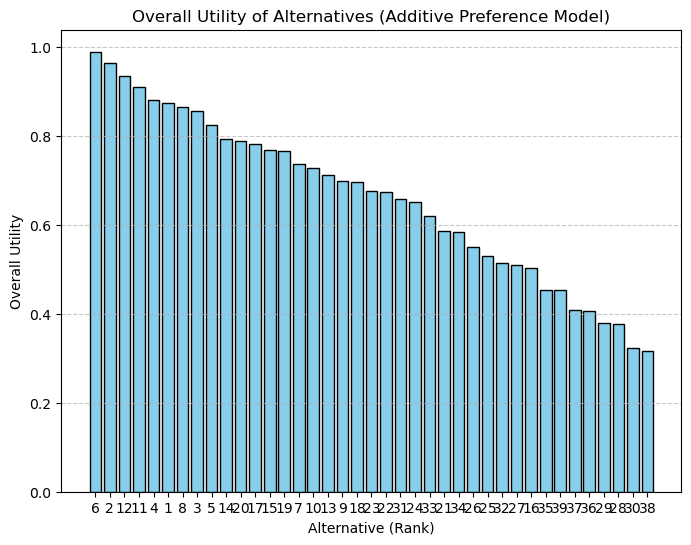

In [44]:
# --- Step 1: Read the Preference Data ---
# Read the Excel file; note that decimals use a comma.
prefs = pd.read_excel("Assets\Data\Preferences.xlsx", decimal=",")
# Rename the column "#changed offices" to a Python-friendly name.
prefs = prefs.rename(columns={"#changed offices": "changed_offices"})

print("Preferences data (first few rows):")
print(prefs.head())

# For demonstration purposes we assume that these six alternatives are the reference (non‐dominated) solutions.
# In your application, df_nd can be the DataFrame containing the non‐dominated solutions computed earlier.
df_nd = prefs.copy()

# --- Step 2: Randomly Generate Piecewise Linear Marginal Value Functions ---
# We will define, for each criterion, a function that maps criterion values to a utility in [0,1].
# Since our criteria are to be minimized (lower is better), we set the highest utility (1) at the best (lowest) value,
# and 0 at the worst (highest) value.

def generate_piecewise_linear_function(x_min, x_max):
    """
    Generates a 3-point piecewise linear function.
    Endpoints: u(x_min)=1, u(x_max)=0.
    The internal breakpoint is chosen randomly and its utility (u_mid) is random in (0,1).
    The points are sorted in increasing order of x.
    Returns:
       x_points: an array of breakpoint x-values.
       u_points: an array of corresponding utility values.
    """
    # Choose a random internal breakpoint between the min and max.
    x_mid = np.random.uniform(x_min, x_max)
    # Choose a random utility for the internal point (ensuring 1 > u_mid > 0).
    u_mid = np.random.uniform(0, 1)
    x_points = [x_min, x_mid, x_max]
    u_points = [1.0, u_mid, 0.0]
    # Sort the breakpoints (and utilities) in increasing order of x.
    sorted_indices = np.argsort(x_points)
    x_points = np.array(x_points)[sorted_indices]
    u_points = np.array(u_points)[sorted_indices]
    return x_points, u_points

# List of criteria (using the column names in the file)
criteria = ['distance', 'max_workload', 'changed_offices']

# For each criterion, determine the observed range in the reference set and generate a marginal value function.
piecewise_functions = {}
for crit in criteria:
    x_min = df_nd[crit].min()
    x_max = df_nd[crit].max()
    x_points, u_points = generate_piecewise_linear_function(x_min, x_max)
    piecewise_functions[crit] = (x_points, u_points)
    print(f"\nMarginal utility for '{crit}':")
    print("  x breakpoints:", x_points)
    print("  u values:      ", u_points)

# --- Step 3: Generate Random Weights for Each Criterion ---
# In an additive model, each criterion receives a weight; here, we generate random weights that sum to 1.
rand_weights = np.random.rand(len(criteria))
rand_weights = rand_weights / rand_weights.sum()
weights_dict = dict(zip(criteria, rand_weights))
print("\nRandomly generated criterion weights:")
for crit, w in weights_dict.items():
    print(f"  {crit}: {w:.3f}")

# Define a helper function to compute the marginal utility by linear interpolation.
def utility_value(x, x_points, u_points):
    """
    Returns the utility of x given breakpoints x_points and corresponding utilities u_points,
    using linear interpolation.
    """
    return np.interp(x, x_points, u_points)

# --- Step 4: Compute Overall Utility for Each Alternative ---
# The overall additive utility is the weighted sum of the marginal utilities.
def overall_utility(row):
    total = 0
    for crit in criteria:
        x_points, u_points = piecewise_functions[crit]
        # Compute marginal utility for the criterion value in the row.
        u = utility_value(row[crit], x_points, u_points)
        total += weights_dict[crit] * u
    return total

# Apply the utility function to each alternative.
df_nd['utility'] = df_nd.apply(overall_utility, axis=1)

# Sort alternatives by overall utility (higher is better).
df_nd_sorted = df_nd.sort_values(by='utility', ascending=False)
print("\nRanked Alternatives with Computed Overall Utilities:")
print(df_nd_sorted[['rank', 'distance', 'max_workload', 'changed_offices', 'utility']])

# --- Step 5: Visualize the Results ---
plt.figure(figsize=(8,6))
# Here we plot a bar chart of the overall utility for each alternative.
plt.bar(df_nd_sorted['rank'].astype(str), df_nd_sorted['utility'], color='skyblue', edgecolor='k')
plt.xlabel("Alternative (Rank)")
plt.ylabel("Overall Utility")
plt.title("Overall Utility of Alternatives (Additive Preference Model)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
